<a href="https://colab.research.google.com/github/subha5622/Melanoma-Skin-Cancer-Detection/blob/main/SSH_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
# !unzip '/content/gdrive/MyDrive/CNN_assignment.zip'

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
   creating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/
   creating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/
   creating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

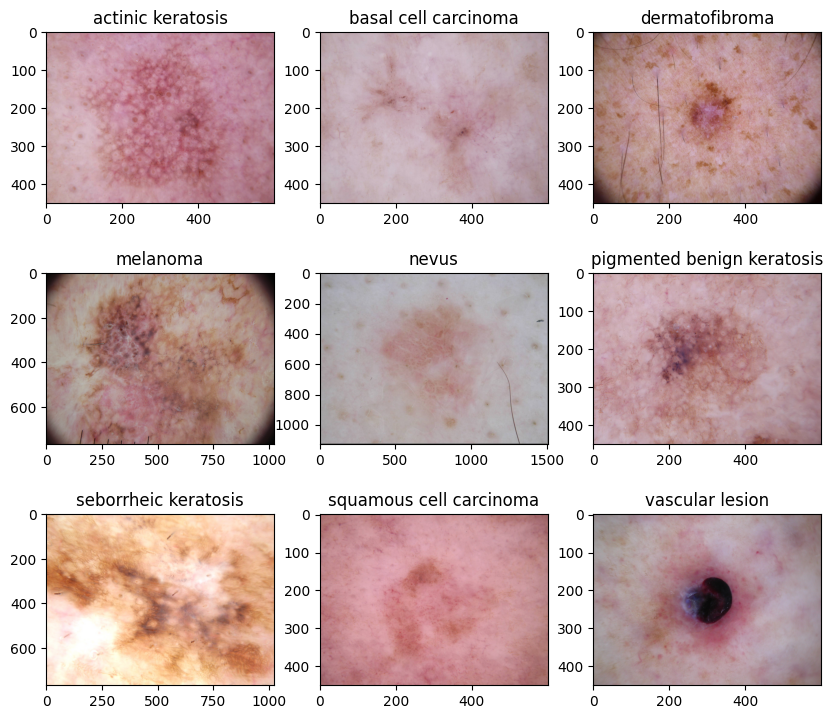

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,12))
for i in range(len(class_names)): 
  plt.subplot(4, 3, i+1)
  if len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) > 0:
    image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
# model.compile(optimizer='your_optimser',
#               loss=your_loss_function_goes_here,
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss=tf.keras.losses.SparseCategoricalCrossentropy
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 26s 164ms/step - loss: 2.0578 - accuracy: 0.2076 - val_loss: 2.0755 - val_accuracy: 0.1902
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 2.0398 - accuracy: 0.1936 - val_loss: 2.0402 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 2.0062 - accuracy: 0.2271 - val_loss: 1.9906 - val_accuracy: 0.2170
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9256 - accuracy: 0.2924 - val_loss: 1.8435 - val_accuracy: 0.3333
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.7882 - accuracy: 0.3477 - val_loss: 1.7588 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 1.7401 - accuracy: 0.3683 - val_loss: 1.6975 - val_accuracy: 0.3624
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6633 - accuracy: 0.4012 - val_loss: 1.6299 - val_accuracy: 0.4295
Epoch 8/20
56/56 [====

### Visualizing training results

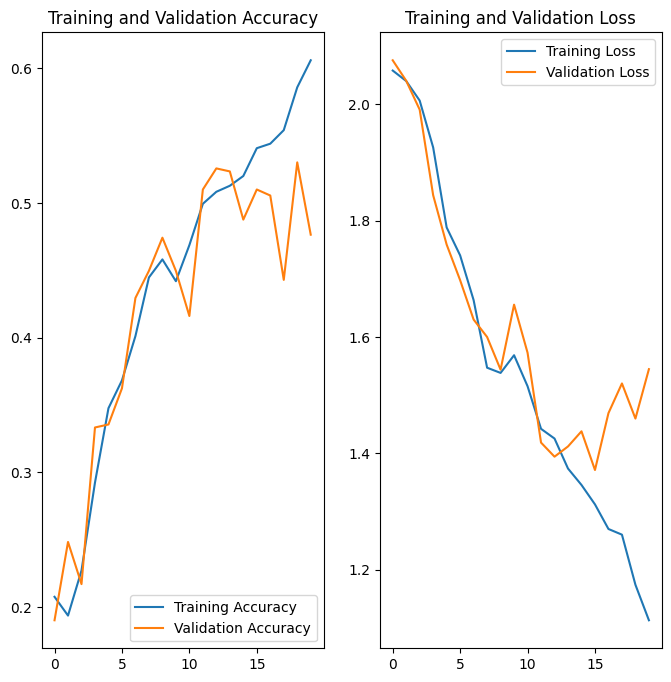

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The model is clearly overfitting as seen the the first chart. Accuracy of the model is increasing for training data set. However when the same model is applied to test data set the accuracy is decreasing. The similar observation is visible in case of Loss calculation, the validation loss decreased till a certain point but started increasing after 10 epochs.

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

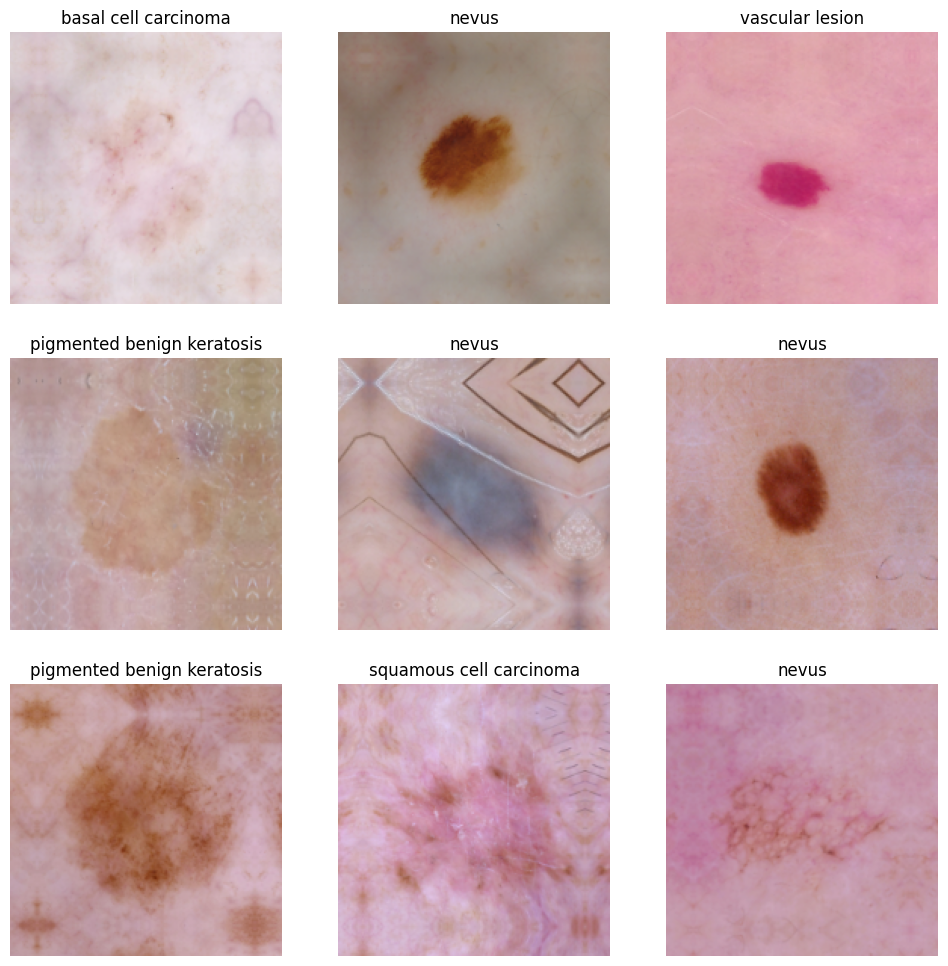

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)
model = Sequential([data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
 ## your training code

Epoch 1/20
56/56 [==============================] - 8s 97ms/step - loss: 2.0573 - accuracy: 0.2037 - val_loss: 2.0452 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 98ms/step - loss: 2.0357 - accuracy: 0.2059 - val_loss: 2.0159 - val_accuracy: 0.2304
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.9580 - accuracy: 0.2545 - val_loss: 1.9308 - val_accuracy: 0.2461
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8607 - accuracy: 0.2801 - val_loss: 1.8666 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 1.7726 - accuracy: 0.3677 - val_loss: 1.7939 - val_accuracy: 0.2998
Epoch 6/20
56/56 [==============================] - 5s 91ms/step - loss: 1.6740 - accuracy: 0.3895 - val_loss: 1.6361 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5741 - accuracy: 0.4481 - val_loss: 1.5829 - val_accuracy: 0.4877
Epoch 8/20
56

### Visualizing the results

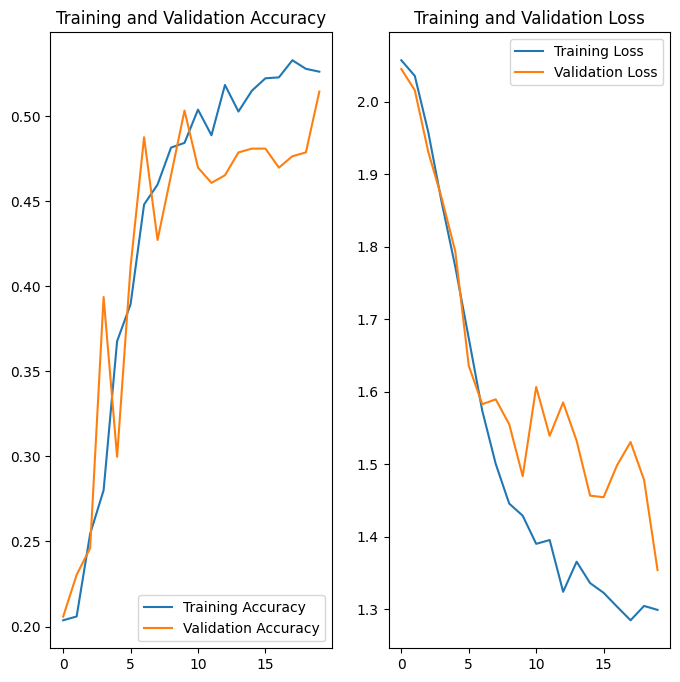

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model is now underfitting, but the results are almost similar for training and validation data set.
Loss is also decreasing with more training.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
...,...,...
2234,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2235,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2236,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2237,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


<BarContainer object of 9 artists>

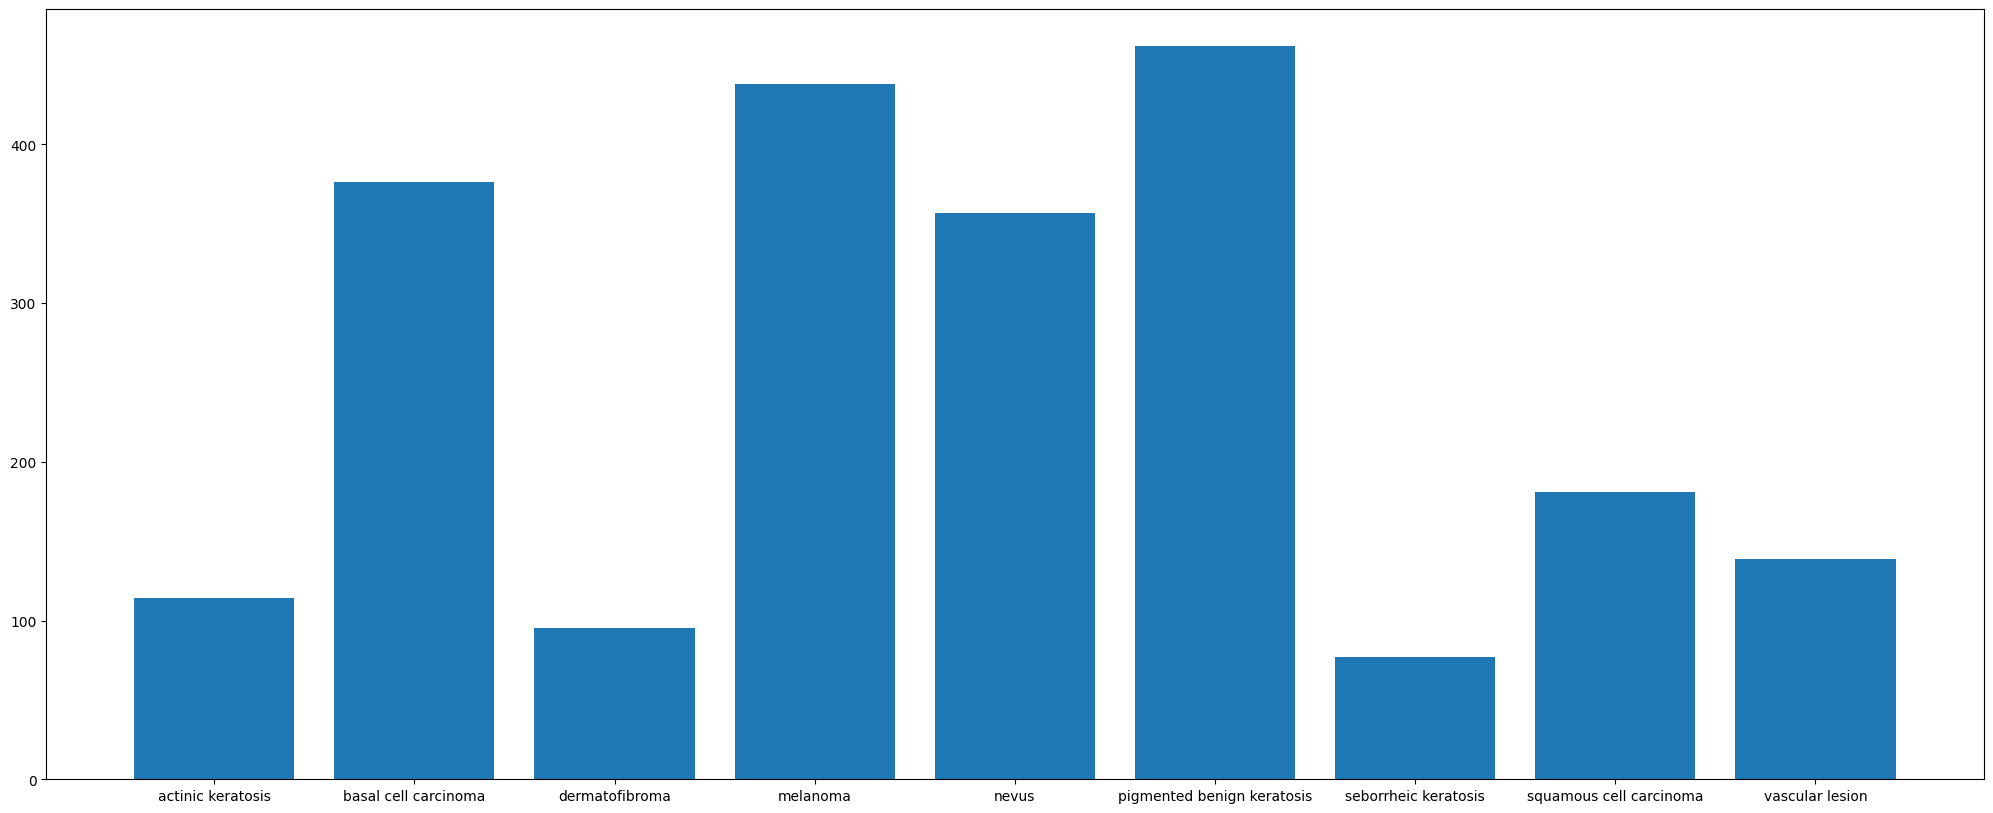

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path_to_training_dataset="To do"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
     if i != ".ipynb_checkpoints":
        p = Augmentor.Pipeline(path_to_training_dataset + i)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85E0054E50>: 100%|██████████| 500/500 [00:20<00:00, 24.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85D57FE4C0>: 100%|██████████| 500/500 [00:25<00:00, 19.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8713656700>: 100%|██████████| 500/500 [00:19<00:00, 25.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2597x2185 at 0x7F85D578D7C0>: 100%|██████████| 500/500 [01:50<00:00,  4.52 Samples/s]


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F85E0122B80>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85E01529A0>: 100%|██████████| 500/500 [00:18<00:00, 27.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F85D57D7A90>: 100%|██████████| 500/500 [00:47<00:00, 10.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F866C6CBDC0>: 100%|██████████| 500/500 [00:19<00:00, 26.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F866C453A30>: 100%|██████████| 500/500 [00:18<00:00, 26.82 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029820.jpg_17841f7d-6ac4-4c12-a882-c6abd32bccb6.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027281.jpg_1fc4a544-665b-4c77-938f-3c97ecfee919.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031266.jpg_00fc7ed3-8d2f-4d6f-afc4-f670e8cd225a.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027371.jpg_b6cf7552-b984-4f7c-b009-b252bd3eb963.jpg',
 'CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026760.jpg_2014fb0d-cc67-4ef8-a5c5-f2a6

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [ ]:
# path_list=[]
# lesion_list=[]
# for i in class_names:
      
#     for j in data_dir_train.glob(i+'/*.jpg'):
#         path_list.append(str(j))
#         lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

,Path,Label
0,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment/Skin cancer ISIC The Internatio...,actinic keratosis
...,...,...
2234,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2235,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2236,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion
2237,CNN_assignment/Skin cancer ISIC The Internatio...,vascular lesion


In [ ]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [ ]:
original_df.value_counts()

Path                                                                                                                            Label                     
CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg           actinic keratosis             1
CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025484.jpg  pigmented benign keratosis    1
CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025431.jpg  pigmented benign keratosis    1
CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025434.jpg  pigmented benign keratosis    1
CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0025454.jpg  pigmented benign keratosis    1
                                             

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset = "training"## Todo choose the correct parameter value, so that only training data is refered to,,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)
# # data_dir_train="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# data_dir_train="images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset ="validation"## Todo choose the correct parameter value, so that only validation data is refered to,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = len(class_names)
model = Sequential([data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
# epochs = 30
## Your code goes here, use 50 epochs.
# history = # your model fit code
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 37s 184ms/step - loss: 2.1365 - accuracy: 0.1669 - val_loss: 2.1916 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 29s 166ms/step - loss: 2.1654 - accuracy: 0.1511 - val_loss: 2.1893 - val_accuracy: 0.1403
Epoch 3/50
169/169 [==============================] - 31s 179ms/step - loss: 2.1785 - accuracy: 0.1419 - val_loss: 2.1870 - val_accuracy: 0.1403
Epoch 4/50
169/169 [==============================] - 29s 166ms/step - loss: 2.1737 - accuracy: 0.1467 - val_loss: 2.1780 - val_accuracy: 0.1403
Epoch 5/50
169/169 [==============================] - 29s 167ms/step - loss: 2.0686 - accuracy: 0.2057 - val_loss: 1.9104 - val_accuracy: 0.2940
Epoch 6/50
169/169 [==============================] - 31s 178ms/step - loss: 1.7507 - accuracy: 0.3457 - val_loss: 1.6562 - val_accuracy: 0.3868
Epoch 7/50
169/169 [==============================] - 29s 166ms/step - loss: 1.5783 - accuracy: 0.3911 - val_loss: 1.5156 - val_accuracy: 0.4

#### **Todo:**  Visualize the model results

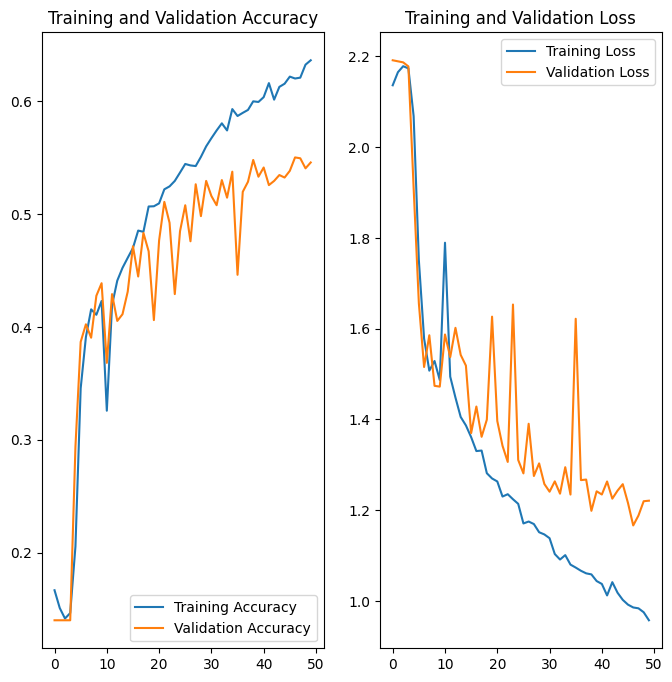

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



There is a slight improvement in the new model.

Validation loss is somewhat constant and validation accuracy seems to be improving.